In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

In [2]:
wine = load_wine(as_frame=True).frame
#wine = wine[wine['target']<2]

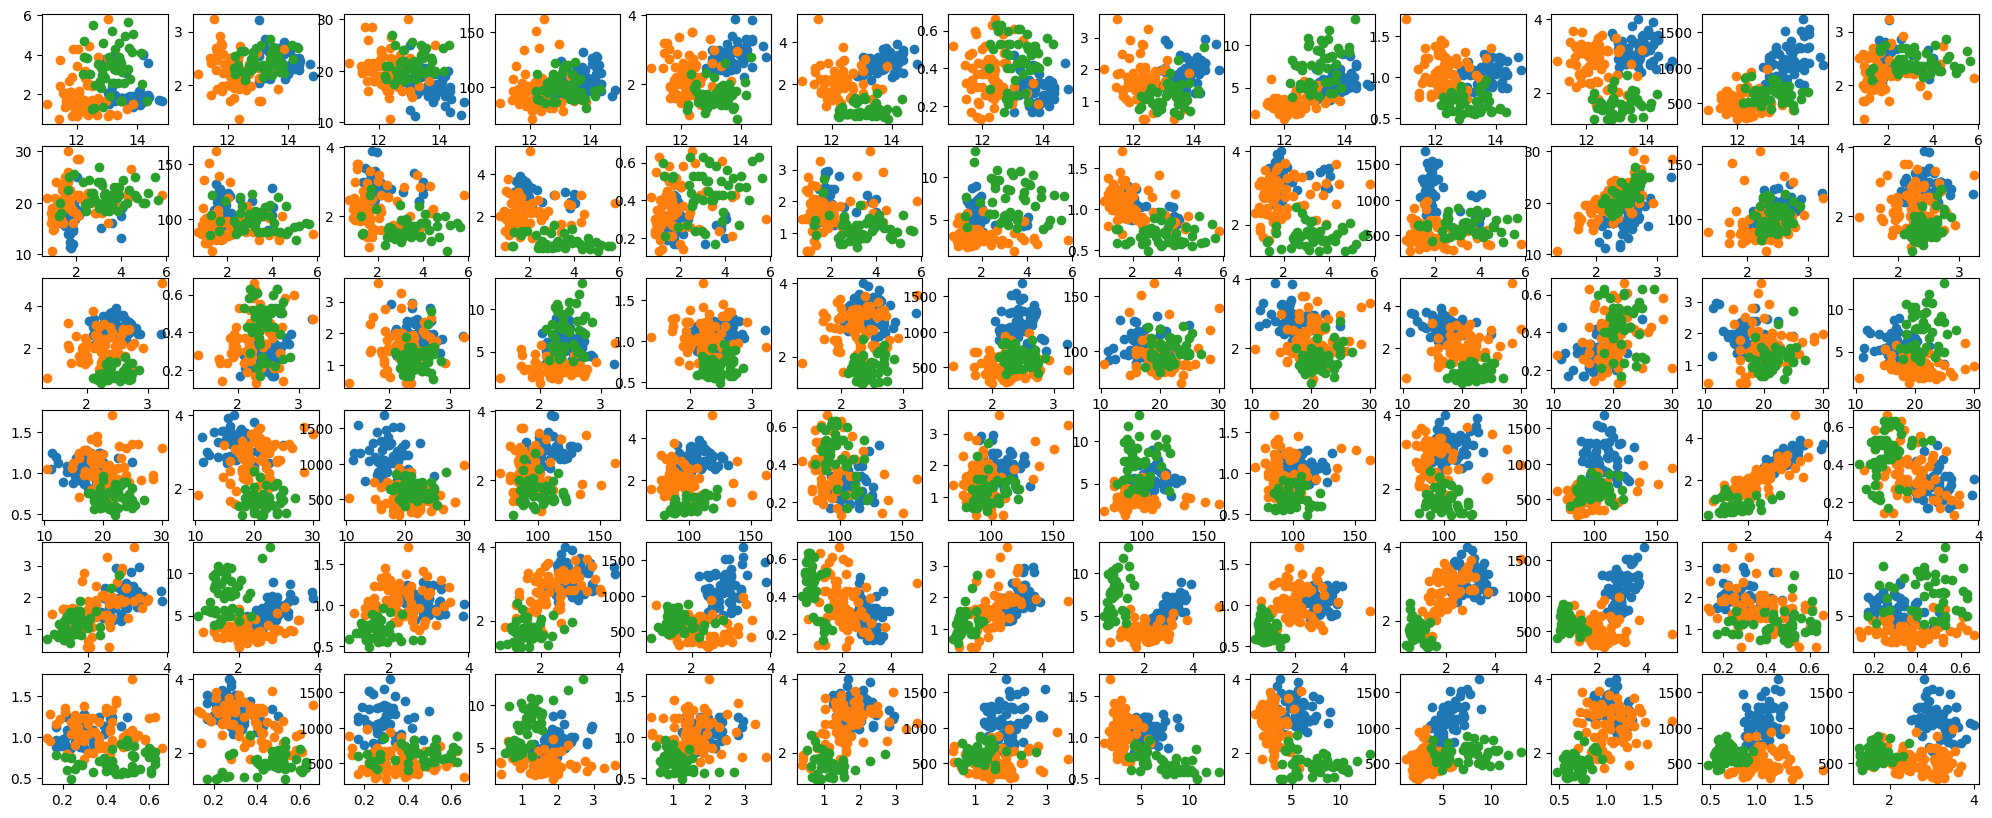

In [3]:
def show_scattering_diagram(df, shape_1, shape_2):
    fig, ax = plt.subplots(shape_1, shape_2)
    fig.set_figheight(10)
    fig.set_figwidth(25)
    for t in df['target'].unique():
        k=0
        for i in range(df.shape[1]-1):
            for j in range(i+1,df.shape[1]-1):
                ax[int(k/shape_2), k % shape_2].scatter(df[df['target']==t].iloc[:,i], df[df['target']==t].iloc[:,j])
                k+=1
show_scattering_diagram(wine, 6, 13)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(wine.drop(columns = "target"), wine['target'], random_state=44)

In [5]:
def Gaussian(x, a, b, c):
    return a*np.exp(-(x-b)**2/c)

def Naive_Bayesian_Classifier(X_train, y_train, X_val):
    priori_y = X_train.groupby(y_train).apply(lambda x: len(x)) / X_train.shape[0]

    M_x = X_train.groupby(y_train).mean()
    D_x = X_train.groupby(y_train).std()

    result = list()
    result_probabilities = list()
    for index_x in X_val.index:
        r = {}
        for index_y in priori_y.index:
            r[index_y] = priori_y[index_y]
            for column in X_val:
                x = X_val[column][index_x]
                a = (1/(np.sqrt(2*np.pi)*D_x[column][index_y]))
                b = M_x[column][index_y]
                c = 2*D_x[column][index_y]**2
                r[index_y] *= Gaussian(x, a, b, c)
        result.append(sorted(r.items(), key=lambda x: x[1], reverse=True)[0][0])
        result_probabilities.append(r)
    return result, pd.DataFrame(result_probabilities)

In [6]:
def dimension_reduction(X_train, y_train, X_val):
    M_x = X_train.groupby(y_train).mean()
    M = M_x.mean(0)
    M_m = M_x-M
    X = np.asarray([X_train.iloc[i]-M_x.loc[y_train.iloc[i]] for i in range(X_train.shape[0])])
    def kronecker_and_sum(df):
        S = np.zeros((df.shape[1], df.shape[1]))
        for row in df:
            x_m = row.reshape(df.shape[1],1)
            S += np.dot(x_m, x_m.T)
        return S
    S_w = kronecker_and_sum(X)
    S_b = kronecker_and_sum(M_m.values)
    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_w)@S_b)
    W = eig_vecs[:, eig_vals>(eig_vals*(eig_vals>0)).mean()]
    #W = eig_vecs[:, eig_vals>=np.sort( eig_vals)[::-1][2]]
    return X_train@W.real, X_val@W.real

def Fishers_Linear_Discriminant(X_train, y_train, X_val):
    priori_y = X_train.groupby(y_train).apply(lambda x: len(x)) / X_train.shape[0]

    M_x = X_train.groupby(y_train).mean().values
    
    Cov_x = np.array([X_train.groupby(y_train).get_group(x).cov().values for x in X_train.groupby(y_train).groups])
    a = (1/(((2*np.pi)**(X_train.shape[1]/2))*np.linalg.det(Cov_x)**2))
    result = list()
    for j in range(X_val.shape[0]):
        res = list()
        for i in range(M_x.shape[0]):
            b = X_val.iloc[j] - M_x[i]
            d = b @ np.linalg.inv(Cov_x[i])
            c = np.exp(-0.5*d @ b.T)
            res.append(a[i]*c*priori_y[i])
        result.append(res)
    res = np.asarray(result)
    return np.argmax(res, axis=1), res

In [7]:
class Logistic_regression:
    def __init__(self, num_class: int, parameters_number: int):
        self.num_class = num_class
        self.parameters_number = parameters_number
        self.tetta = np.random.random((parameters_number,num_class))

    def backword(self, X, Y, pred, a):
        loss = self.loss(Y, pred)
        self.tetta -= a*np.dot(X.T, pred-Y)/X.shape[0]
        #self.tetta -= a*np.dot(X.T, pred-Y)/X.shape[0]

    def loss(self, Y, pred):
        Y_mean = (Y-pred).mean(0)
        return ((Y - Y_mean)**2).mean(0)**0.5

    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    def anover_sigmoid(self, X):
        return np.exp(X) / (np.exp(X) + 1)
    
    def stable_sigmoid(self, X):
        return self.sigmoid(X*(X >= 0))*(X >= 0) + self.anover_sigmoid(X*(X < 0))*(X < 0)

    def predict(self, X):
        y = np.dot(X, self.tetta)
        y = self.stable_sigmoid(y)
        return y

In [8]:
class K_nearest:
    def __init__(self, k:int, X, Y):
        self.X = X
        self.Y = Y
        self.K = k

    def predict(self, X):
        dist = np.abs(self.X[None,:,:]-X[:,None,:])
        radius = ((dist**2).sum(2))**0.5
        nearest = np.argsort(radius)[:,:self.K]
        Y = self.Y[nearest].mean(1)
        return Y


In [9]:
X= X_train.values/X_train.values.max(0)
x= X_val.values/X_val.values.max(0)
y=np.array([[1. if y_train.values[i]==j else 0. for j in range(3)] for i in range(len(y_train))])

K_n = K_nearest(10, X, y)
pred_prob_k = K_n.predict(x)
predicted_k = np.argmax(pred_prob_k, 1)

In [10]:
lg = Logistic_regression(3, 13)
loss=np.zeros((10000, 3))
for i in range(10000):
    out = lg.predict(X)
    loss[i,:] = lg.loss(y, out)
    lg.backword(X, y, out, 0.02)
pred_prob_l = lg.predict(x)
predicted_l = np.argmax(pred_prob_l, 1)

In [11]:
X, x = dimension_reduction(X_train, y_train, X_val)
predicted_f, pred_prob_f = Fishers_Linear_Discriminant(X, y_train, x)

In [12]:
predicted, pred_prob = Naive_Bayesian_Classifier(X_train, y_train, X_val)

In [13]:
(y_val==predicted).sum()/y_val.shape[0]

0.9333333333333333

In [14]:
class Metrics:
    def __init__(self, lables, predicted):
        leble = lables.unique()
        self.matrix = np.zeros((leble.size, leble.size))
        for i in range(leble.size):
            for j in range(leble.size):
                self.matrix[i, j]=((leble[j]==predicted)*(lables==leble[i])).sum()

        # self.TP = (lables==predicted).sum()
        # self.FP = self.TN = self.FN = 0
        # for lable in lables.unique():
        #     self.FP += ((predicted == lable)*(lables!=predicted)).sum()
        #     self.TN += ((predicted != lable)*(lables!=predicted)).sum()
        #     self.FN += ((predicted != lable)*(lables==lable)).sum()
    
    def accuracy(self):
        return np.array([self.matrix.diagonal().sum()/self.matrix.sum()
                         if self.matrix.diagonal().sum() != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def precision(self):
        return np.array([self.matrix[i,i]/self.matrix[i,:].sum()
                         if self.matrix[i,i] != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def recall(self):
        return np.array([self.matrix[i,i]/self.matrix[:,i].sum()
                         if self.matrix[i,i] != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def FPR(self):
        return np.array([(self.matrix[i,:].sum()-self.matrix[i,i])/(self.matrix[:,i].sum()+self.matrix[i,:].sum()-2*self.matrix[i,i])
                         if (self.matrix[i,:].sum()-self.matrix[i,i]) != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def TPR(self):
        return np.array([self.matrix[i,i]/self.matrix[:,i].sum()
                         if self.matrix[i,i] != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def F(self, b = 1):
        b=b**2
        return (1+b)*self.precision()*self.recall()/(b*self.precision()+self.recall())
    def all(self, b=1):
        return pd.DataFrame(np.array([self.accuracy(), self.precision(), self.recall(), self.FPR(), self.TPR(), self.F(b)]).T,
                            columns=["accuracy", "precision", "recall", "FPR", "TPR", "F"])

    # def accuracy(lables, predicted):
    #     return Metrics(lables, predicted).accuracy()
    # def precision(lables, predicted):
    #     return Metrics(lables, predicted).precision()
    # def recall(lables, predicted):
    #     return Metrics(lables, predicted).recall()
    # def FPR(lables, predicted):
    #     return Metrics(lables, predicted).FPR()
    # def TPR(lables, predicted):
    #     return Metrics(lables, predicted).TPR()
    # def F(lables, predicted):
    #     return Metrics(lables, predicted).F(b)

In [15]:
metrics_k = Metrics(y_val, predicted_k)
metrics_k.all()

,accuracy,precision,recall,FPR,TPR,F
0,0.933333,1.000000,0.857143,0.0,0.857143,0.923077
1,0.933333,0.833333,1.000000,1.0,1.000000,0.909091
2,0.933333,1.000000,1.000000,0.0,1.000000,1.000000


In [16]:
metrics_l = Metrics(y_val, predicted_l)
metrics_l.all()

,accuracy,precision,recall,FPR,TPR,F
0,1.0,1.0,1.0,0.0,1.0,1.0
1,1.0,1.0,1.0,0.0,1.0,1.0
2,1.0,1.0,1.0,0.0,1.0,1.0


In [17]:
metrics = Metrics(y_val, predicted)
metrics.all()

,accuracy,precision,recall,FPR,TPR,F
0,0.933333,0.944444,0.944444,0.500000,0.944444,0.944444
1,0.933333,0.888889,0.941176,0.666667,0.941176,0.914286
2,0.933333,1.000000,0.900000,0.000000,0.900000,0.947368


In [18]:
metrics_f = Metrics(y_val, predicted_f)
metrics_f.all()

,accuracy,precision,recall,FPR,TPR,F
0,0.955556,1.000000,0.9,0.0,0.9,0.947368
1,0.955556,0.888889,1.0,1.0,1.0,0.941176
2,0.955556,1.000000,1.0,0.0,1.0,1.000000


In [19]:
wine = wine[wine['target']<2]

X_train, X_val, y_train, y_val = train_test_split(wine.drop(columns = "target"), wine['target'], random_state=44)

X, x = dimension_reduction(X_train, y_train, X_val)
predicted_f, pred_prob_f = Fishers_Linear_Discriminant(X, y_train, x)

predicted, pred_prob = Naive_Bayesian_Classifier(X_train, y_train, X_val)

In [20]:
pp = np.array(pred_prob)/np.array(pred_prob.T.sum(0))[:, None]
pp_f = pred_prob_f/pred_prob_f.T.sum(0)[:, None]

In [21]:
def get_fp_tp(val, proba, th):
    pred = np.hsplit(proba>th, 2)[1]
    pred = pred.reshape((len(val)))
    met = Metrics(val, pred)
    return np.array((met.TPR()[1], met.FPR()[1]))

In [22]:
thresholds = np.linspace(0, 1, 1001)[:1000]
m =np.array([ get_fp_tp(y_val, pp, th) for th in thresholds])
m_f =np.array([ get_fp_tp(y_val, pp_f, th) for th in thresholds])

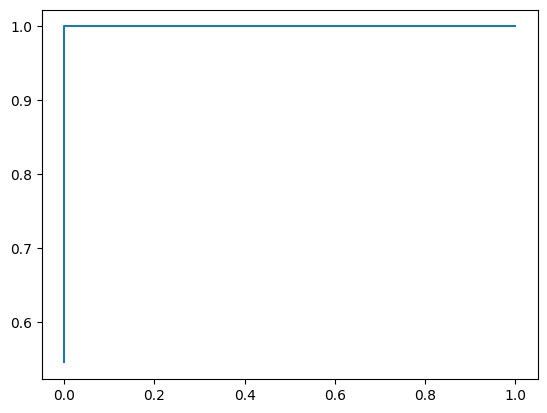

In [23]:
plt.plot(m[:,1], m[:,0]);

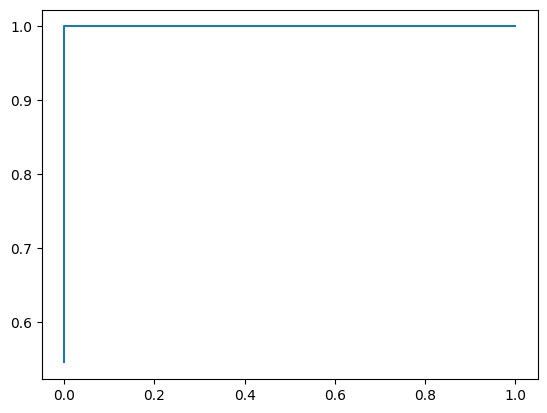

In [24]:
plt.plot(m_f[:,1], m_f[:,0]);